In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg
import gdown

# Load the datasets

In [2]:
gdown.download(
    'https://drive.google.com/uc?id=1E3AT2wztvswn3p_N5kWEmk0_ZHaT3OWH',
    'chen2019-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1E3AT2wztvswn3p_N5kWEmk0_ZHaT3OWH
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/chen2019-expressions.h5ad
9.00MB [00:00, 76.8MB/s]


'chen2019-expressions.h5ad'

In [3]:
scrna = sc.read('chen2019-expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 4793 × 4000
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Batch_colors', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=13SdXwNDjG_UbnpCUnYqc2iHLwXEAjxNc',
    'chen2019-peaks.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=13SdXwNDjG_UbnpCUnYqc2iHLwXEAjxNc
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/chen2019-peaks.h5ad
106MB [00:00, 129MB/s]  


'chen2019-peaks.h5ad'

In [5]:
scatac = sc.read_h5ad('chen2019-peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 4793 × 40623
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'Batch_colors', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [27]:
model = mtg.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['RNA'], ['ATAC']],
    pair_groups=[[0], [0]],
    condition=False,
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2, # don't have here as 1 dataset
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [28]:
model.train(
    n_iters=10000,
    batch_size=256,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=3500,
    validate_every=1000,
    verbose=1
)

 |████████████████████| 100.0% iter=10000/10000, time=29.52(s), loss=0.2248, recon=0.2245, kl=24.2708, integ=0.0000, cycle=0.0000, val_loss=0.2254, val_recon=0.2252, val_kl=23.5700, val_integ=0.0000, val_cycle=0.0000

### Plot training history

In [29]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,1000,0.226505,0.226484,11.483170,0.0,0.0,0.227944,0.227908,12.746093,0,0
1,2000,0.224845,0.224782,13.914016,0.0,0.0,0.227930,0.227862,12.016870,0,0
2,3000,0.229792,0.229693,13.145070,0.0,0.0,0.226079,0.225961,13.783273,0,0
3,4000,0.230836,0.230695,14.390585,0.0,0.0,0.225907,0.225760,14.648683,0,0
4,5000,0.216554,0.216395,15.902370,0.0,0.0,0.225482,0.225331,15.153717,0,0
5,6000,0.228537,0.228365,17.238020,0.0,0.0,0.225347,0.225182,16.458546,0,0
6,7000,0.231049,0.230857,19.243961,0.0,0.0,0.225305,0.225114,19.032806,0,0
7,8000,0.217905,0.217691,21.450426,0.0,0.0,0.225225,0.225013,21.149107,0,0
8,9000,0.225658,0.225423,23.554781,0.0,0.0,0.225260,0.225036,22.481281,0,0
9,9999,0.224759,0.224516,24.270832,0.0,0.0,0.225445,0.225210,23.570015,0,0


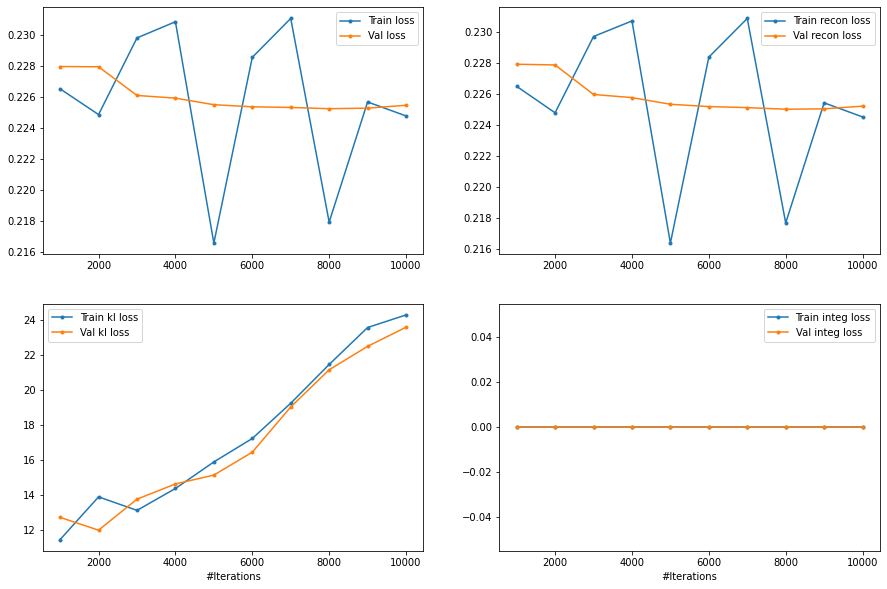

In [30]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Validation

### UMAP plot of the latent space

In [31]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['RNA'], ['ATAC']],
    pair_groups=[[0], [0]],
    batch_size=256,
    layers=[['count'], [None]]
)
z

AnnData object with n_obs × n_vars = 4793 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [32]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


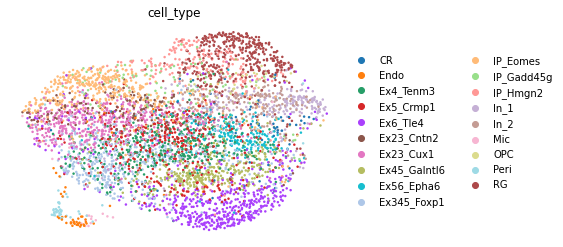

In [33]:
sc.pl.umap(z, color='cell_type', ncols=1, frameon=False)

In [22]:
z.obs_names = z.obs.barcode
np.sum(z.obs_names != scrna.obs_names)

0

In [23]:
z.obs = scrna.obs
z.obs

,Batch,Barcode,cell_type,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
GGTTGCGATTCA,12A,GGTTGCGATTCA,IP_Eomes,453,453,6.118097,531.0,6.276643,0.0,0.000000,0.00000
TCGAGAACGTAC,12A,TCGAGAACGTAC,In_2,744,744,6.613384,953.0,6.860664,0.0,0.000000,0.00000
GTGATTACCAGG,12A,GTGATTACCAGG,Ex345_Foxp1,475,475,6.165418,656.0,6.487684,0.0,0.000000,0.00000
GCCTCGGGAATT,12A,GCCTCGGGAATT,In_1,756,756,6.629363,1033.0,6.941190,0.0,0.000000,0.00000
ATGTCCAAGTAC,12A,ATGTCCAAGTAC,Ex45_Galntl6,709,709,6.565265,941.0,6.848005,1.0,0.693147,0.10627
...,...,...,...,...,...,...,...,...,...,...,...
TCCCGCAGTGGT,19A,TCCCGCAGTGGT,Ex5_Crmp1,236,236,5.468060,261.0,5.568345,0.0,0.000000,0.00000
CATGTTTGCAAA,19A,CATGTTTGCAAA,Ex23_Cntn2,289,289,5.669881,311.0,5.743003,0.0,0.000000,0.00000
GTGCACGCGTGG,19A,GTGCACGCGTGG,Ex6_Tle4,245,245,5.505332,262.0,5.572154,0.0,0.000000,0.00000
CACCTCCAGCGA,19A,CACCTCCAGCGA,RG,320,320,5.771441,363.0,5.897154,0.0,0.000000,0.00000


In [24]:
z.write('../data/integrated/multigrate/chen-multigrate.h5ad')

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [2]:
!rm 'chen2019-expressions.h5ad'
!rm 'chen2019-peaks.h5ad'